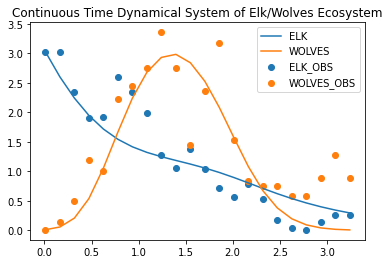


Optimal Theta Values


,0,1,2,3,4
0,a,b,c,d,K
1,-0.99117,-0.21964,8.353016,6.962148,-1805585.627957



Optimal Cost
5.819014877747755


In [72]:
import numpy as np
from scipy.optimize import least_squares
from scipy.integrate import odeint as odeint
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("elkwolves.txt", sep=" ")

#normalize data around mean and stdev
df = df - df.mean()
df = df / df.std()
df = df - df.min() + 0.01 #make sure there are no zero values (equilibrium)

def state(currState, t, thetas): #define differential equations, returns two length vector

    x, y = currState #unpack initial states 
    a, b, c, d, K = thetas #and theta values
    
    xprime = (a * x * (1 - (x / K))) - (b * x * y)
    yprime = (-1 * (c * y)) + (d * x * y)
    
    updatedState = [xprime, yprime]
    return updatedState

def integrate(thetas): #integrate over diff equations at t points in data
    
    t = df["Year"].to_numpy()
    initialState = np.array([df["Elk"][0],df["Wolves"][0]]) #initial state defined as state where data starts
    y_pred = odeint(state, initialState, t, args=(thetas,))
    
    return y_pred

def residuals(thetas):
    
    preds = integrate(thetas)
    
    residuals = np.array(preds - df[["Elk", "Wolves"]]) #obejctive function of our minimization
    residuals = residuals.flatten() #remove dimensionality
    
    return residuals


thetasInit = np.random.normal(0,0.2,5)#randomize initial thetas (none will be zero)

result = least_squares(residuals, thetasInit, method="lm") #run LM algorithm to find min normed cost
thetasStar = result["x"] 
cost = result["cost"]

modelMap = integrate(thetasStar) #run integrate() method on opt params to get realized prediction vals

plt.plot(df["Year"], modelMap.T[0], label="ELK") 
plt.plot(df["Year"], modelMap.T[1], label="WOLVES")
plt.scatter(df["Year"], df["Elk"], label="ELK_OBS")
plt.scatter(df["Year"], df["Wolves"], label="WOLVES_OBS")
plt.legend()
plt.title("Continuous Time Dynamical System of Elk/Wolves Ecosystem")
plt.show()

resultsTbl = pd.DataFrame([["a","b","c","d", "K"],thetasStar])

print("\nOptimal Theta Values")
display(resultsTbl)
print("\nOptimal Cost")
print(cost)

[-9.91166348e-01 -2.19638663e-01  8.35304045e+00  6.96215473e+00
 -1.75358308e+06]


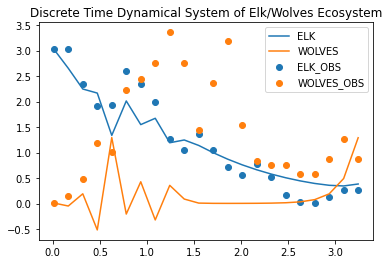


Optimal Theta Values


,0,1,2,3,4
0,a,b,c,d,K
1,-6.655659,3.186949,24.376902,18.278335,-1753554.674665



Optimal Cost
32.32717646783911


In [65]:
def state_discretize(currState, dt, thetas): #derived expresssion on paper; now takes dt as input
    x, y = currState
    a, b, c, d, K = thetas
    
    xdiscrete = dt*((a * x * (1 - (x / K))) - (b * x * y) + x) #major difference is the dt scalar and adding previous x state at the end
    ydiscrete = dt*((-1 * (c * y)) + (d * x * y) + y) #same here
    
    updatedState = [xdiscrete, ydiscrete]
    return updatedState

def integrate_fwd(thetas): #no need to integrate since we have discrete steps now
    
    t = df["Year"].to_numpy()
    initialState = np.array([df["Elk"][0],df["Wolves"][0]])
    
    predMat = np.empty((t.shape[0], initialState.shape[0])) #init n x p matrix for predictions (n is num of obs, p is num of state vars)
    predMat[0] = initialState
    
    nextState = initialState #init next state
    
    for time in range(1, t.shape[0]): #iterate through time points in dataset to realize preds
        
        dt = t[time - 1] - t[time] #dt is delta between each t
        nextState = state_discretize(nextState, dt, thetas) #get new state
        predMat[time] = nextState #fill the matrix
    
    return predMat
    
    
def residuals_discrete(thetas): #same residuals func
    
    preds = integrate_fwd(thetas)
    residuals = np.array(preds - df[["Elk", "Wolves"]])
    residuals = residuals.flatten() 
    
    
    return residuals


#thetasInit = np.random.standard_normal(5) #this kind of causes instability in model output, so:
print(thetasStar)
thetasInit = np.array(thetasStar) #use star values from CT model

result = least_squares(residuals_discrete, thetasInit, method="lm") #run LM
thetasStarDiscrete = result["x"]
cost = result["cost"]

modelMapDiscrete = integrate_fwd(thetasStarDiscrete) #find realized preds for optimized params 

plt.plot(df["Year"], modelMapDiscrete.T[0], label="ELK") 
plt.plot(df["Year"], modelMapDiscrete.T[1], label="WOLVES")
plt.scatter(df["Year"], df["Elk"], label="ELK_OBS")
plt.scatter(df["Year"], df["Wolves"], label="WOLVES_OBS")
plt.legend()
plt.title("Discrete Time Dynamical System of Elk/Wolves Ecosystem")
plt.show()

resultsTbl = pd.DataFrame([["a","b","c","d", "K"], thetasStarDiscrete])

print("\nOptimal Theta Values")
display(resultsTbl)
print("\nOptimal Cost")
print(cost)



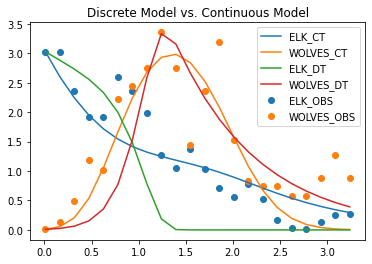

In [81]:
#compare preds
plt.plot(df["Year"], modelMap.T[0], label="ELK_CT") 
plt.plot(df["Year"], modelMap.T[1], label="WOLVES_CT")

plt.plot(df["Year"], modelMapDiscrete.T[0], label="ELK_DT") 
plt.plot(df["Year"], modelMapDiscrete.T[1], label="WOLVES_DT")
plt.scatter(df["Year"], df["Elk"], label="ELK_OBS")
plt.scatter(df["Year"], df["Wolves"], label="WOLVES_OBS")
plt.legend()
plt.title("Discrete Model vs. Continuous Model")
plt.show()

In [82]:
J = result.jac

sigmaSquared = ((result.cost * 2) / (np.sqrt(len(df["Year"]) - thetasStar.shape[0]))) ** 2 #cost/(m-n)^2

FIM =  J.T @ J * (1 / sigmaSquared) #FIM = J'J/sigma^2
print("FIM")
print(FIM)
cov = np.linalg.inv(FIM) #cov = inv FIM
print("\nVariance in Params")
print(np.diag(cov))

FIM
[[ 4.38870973e+00 -1.43736162e+00 -1.56462229e+00  1.30046832e+00
  -3.68617407e-11]
 [-1.43736162e+00  7.21208113e-01  7.60845289e-01 -2.83045835e-01
   1.12712188e-11]
 [-1.56462229e+00  7.60845289e-01  1.17081267e+00 -4.01483362e-01
   1.23830904e-11]
 [ 1.30046832e+00 -2.83045835e-01 -4.01483362e-01  6.04648885e-01
  -1.13977077e-11]
 [-3.68617407e-11  1.12712188e-11  1.23830904e-11 -1.13977077e-11
   3.12205823e-22]]

Variance in Params
[3.33038654e+03 4.05651842e+02 3.37146777e+00 8.53847593e+00
 3.76139629e+25]


0.0: I Initial Eq
3.333333333333333: C Initial Eq
13.333333333333332: GDP Initial Eq


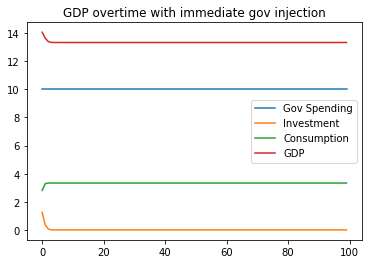

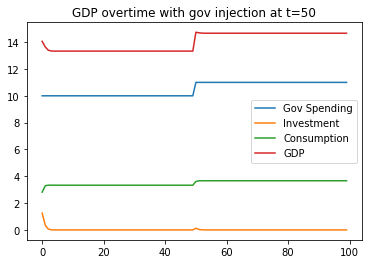

In [79]:
m = 0.25
mu = 0.5
G = 10

def sim(x0, iter, iterInject, pctInject, chartTitle):
    arrayG = []
    arrayI = []
    arrayC = []
    arrayY = []
    
    I, C, G = x0
    
    for i in range(iter):
        
        if i == iterInject & iterInject > 5:

            G = G*(1+pctInject)
            print(str(I) + ": I Initial Eq")
            print(str(C) + ": C Initial Eq")
            print(str(Y) + ": GDP Initial Eq")
            
        I = mu*(m-1)*C + mu*m*I + mu*m*G
        C = m*C + m*I + m*G
        Y = C+I+G
        arrayG.append(G)
        arrayI.append(I)
        arrayC.append(C)
        arrayY.append(Y)
    
    plt.plot(range(100), arrayG, label = "Gov Spending")
    plt.plot(range(100), arrayI, label = "Investment")
    plt.plot(range(100), arrayC, label = "Consumption")
    plt.plot(range(100), arrayY, label = "GDP")
    plt.legend()
    plt.title(chartTitle)




sim([0,0,G], 100, 1, .1, "GDP overtime with immediate gov injection")
plt.figure()
sim([0,0,G], 100, 50, .1, "GDP overtime with gov injection at t=50")

Playing around with when the 10% spending increase occurs, we see that future equilibrium is not amplified by whether or not the injection occurs when the system is in equilibrium. The system, does imply however, that new government spending, no matter at which economic cycle, will cause a long term higher equilibrium (because GDP is measured in $, this will probably just lead to inflation in long term equilibrium). The small bumps before equilibrium might be a short-term increase in real GDP. 

In [ ]:
!jupyter nbconvert --execute --to html HW7.ipynb